In [1]:
from collections import defaultdict
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import ensemble, linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import tensorflow
import time

In [2]:
# access to REDD datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data pre-processing and exploration**

In [3]:
class dataPreparation:

  def __init__(self, house_num):

    # root path
    self.path = '/content/drive/MyDrive/energy_disaggregation/low_freq'
    self.house_num = house_num

  def show_data(self):

    new_path = self.path + '/house_' + str(self.house_num)
    data = list()
    # separate channel data and labels
    for file in os.listdir(new_path):
      if 'channel' in file:
        data.append(file)
      else:
        label = file
      data.sort(key=lambda x: int(x.split('.')[0].split('_')[1]))
    # read labels
    label = pd.read_table(new_path + '/' + label, names = ['label'])['label'].to_list()
    print('house{} label: {}'.format(self.house_num, label))
    print('house{} data: {}'.format(self.house_num, data))

    return label, data, new_path
  
  def merge(self, label, data, new_path):

    
    df = pd.read_table(new_path + '/' + str(data[0]), sep = ' ', names = ['UTC', label[0]])
    # merge all appliances data
    for i in range(1, len(data)):
      temp = pd.read_table(new_path + '/' + str(data[i]), sep = ' ', names = ['UTC', label[i]])
      df = df.merge(temp, how = 'inner', on = 'UTC')
    print('house{} data aggregation finished!'.format(self.house_num))

    return df
  
  def transfer_time(self, df):

    #determine if weekend or weekday
    def isWeekend(day):

      if day in {0,1,2,3,4}:
        return False
      return True

    # tranfer UTC to local datetime, feature engineering on datetime
    df.insert(0, 'datetime', '')
    df['datetime'] = pd.to_datetime(df['UTC'], unit = 's')
    df.insert(1, 'Month', '')
    df.insert(2, 'Day', '')
    df.insert(3, 'Hour', '')
    df.insert(4, 'isWeekend', '')

    df['Month'] = df['datetime'].dt.month
    df['Day'] = df['datetime'].dt.day
    df['Hour'] = df['datetime'].dt.hour
    df['isWeekend'] = df['datetime'].dt.dayofweek.apply(isWeekend)

    df = df.drop(columns = ['UTC'])
    print('house{} shape: {}\n'.format(self.house_num, df.shape))

    return df



In [4]:
# store all data info in a single dictionary
data_frames = dict()
labels = dict()

for i in range(1, 7):
  dp = dataPreparation(i)
  label, data, path = dp.show_data()
  labels[i] = label
  df = dp.merge(label, data, path)
  df = dp.transfer_time(df)
  data_frames[i] = df


house1 label: ['1 mains', '2 mains', '3 oven', '4 oven', '5 refrigerator', '6 dishwaser', '7 kitchen_outlets', '8 kitchen_outlets', '9 lighting', '10 washer_dryer', '11 microwave', '12 bathroom_gfi', '13 electric_heat', '14 stove', '15 kitchen_outlets', '16 kitchen_outlets', '17 lighting', '18 lighting', '19 washer_dryer', '20 washer_dryer']
house1 data: ['channel_1.dat', 'channel_2.dat', 'channel_3.dat', 'channel_4.dat', 'channel_5.dat', 'channel_6.dat', 'channel_7.dat', 'channel_8.dat', 'channel_9.dat', 'channel_10.dat', 'channel_11.dat', 'channel_12.dat', 'channel_13.dat', 'channel_14.dat', 'channel_15.dat', 'channel_16.dat', 'channel_17.dat', 'channel_18.dat', 'channel_19.dat', 'channel_20.dat']
house1 data aggregation finished!
house1 shape: (406748, 25)

house2 label: ['1 mains', '2 mains', '3 kitchen_outlets', '4 lighting', '5 stove', '6 microwave', '7 washer_dryer', '8 kitchen_outlets', '9 refrigerator', '10 dishwaser', '11 disposal']
house2 data: ['channel_1.dat', 'channel_2.d

In [5]:
house1 = data_frames[1]
house1.head()

,datetime,Month,Day,Hour,isWeekend,1 mains,2 mains,3 oven,4 oven,5 refrigerator,6 dishwaser,7 kitchen_outlets,8 kitchen_outlets,9 lighting,10 washer_dryer,11 microwave,12 bathroom_gfi,13 electric_heat,14 stove,15 kitchen_outlets,16 kitchen_outlets,17 lighting,18 lighting,19 washer_dryer,20 washer_dryer
0,2011-04-18 13:22:13,4,18,13,False,222.20,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
1,2011-04-18 13:22:16,4,18,13,False,223.17,119.19,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2,2011-04-18 13:22:20,4,18,13,False,223.60,118.92,0.0,0.0,6.0,0.0,34.0,22.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
3,2011-04-18 13:22:23,4,18,13,False,222.91,119.16,0.0,0.0,6.0,1.0,35.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,65.0,46.0,0.0,0.0
4,2011-04-18 13:22:26,4,18,13,False,222.94,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0


In [6]:
# generate demo datasets
mask1 = (house1['datetime'] >= '2011-05-01 00:00:00') & (house1['datetime'] <= '2011-05-02 00:00:00')
test1 = house1.loc[mask1][['datetime', '1 mains', '2 mains']]
test1.to_csv('/content/drive/MyDrive/energy_disaggregation/low_freq/demo_test/house1_0501_0502.dat', index=False)

In [7]:
test1

,datetime,1 mains,2 mains
234362,2011-05-01 00:00:01,126.71,117.07
234363,2011-05-01 00:00:04,130.63,116.56
234364,2011-05-01 00:00:08,130.26,116.53
234365,2011-05-01 00:00:11,130.81,117.07
234366,2011-05-01 00:00:15,126.22,117.11
...,...,...,...
256811,2011-05-01 23:59:45,137.49,118.13
256812,2011-05-01 23:59:49,137.81,118.40
256813,2011-05-01 23:59:52,137.63,118.33
256814,2011-05-01 23:59:56,138.33,118.60


In [8]:
class dataExploration:

  def __init__(self, house_num, df):
    self.house_num = house_num
    self.df = df

  # measure duration in days
  def measure_duration(self):

    duration = set()
    for timestamp in self.df['datetime'].values:
      duration.add(str(timestamp)[:10])
    duration = sorted(duration)

    def days_count(d1, d2):
        start = datetime.strptime(d1, "%Y-%m-%d")
        end = datetime.strptime(d2, "%Y-%m-%d")
        return abs((end - start).days)
    
    print('House{}: start {}, end {}, duration {} days'.format(self.house_num, duration[0], duration[-1], days_count(duration[0], duration[-1])))
    return days_count(duration[0], duration[-1])

  def rank_appliance(self):
    
    appliances = list()

    for attr in self.df.columns:
      if attr not in ['datetime', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'isWeekend', '1 mains', '2 mains']:
        appliances.append((attr, self.df[attr].sum()))
        appliances.sort(key=lambda x: -x[1])
        top5 = [pair[0] for pair in appliances[:5]]

    print('house{} top 5 appliances: {}'.format(self.house_num, top5))
    return top5

House1: start 2011-04-18, end 2011-05-24, duration 36 days
House2: start 2011-04-18, end 2011-05-22, duration 34 days
House3: start 2011-04-16, end 2011-05-31, duration 45 days
House4: start 2011-04-17, end 2011-06-04, duration 48 days
House5: start 2011-04-18, end 2011-06-01, duration 44 days
House6: start 2011-05-21, end 2011-06-14, duration 24 days


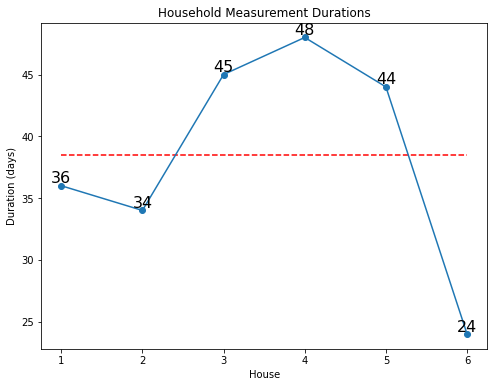

In [9]:
durations = list()

for i, df in data_frames.items():
  de = dataExploration(i, df)
  durations.append(de.measure_duration())

# plot
houses = range(1, 7)
plt.figure(figsize=(8, 6))
plt.plot(houses, durations, marker='o')
plt.title('Household Measurement Durations')
plt.xlabel('House')
plt.ylabel('Duration (days)')
for i, j in zip(houses, durations):
    plt.text(i, j, j, ha='center', va='bottom', fontsize=16)
plt.hlines(y=sum(durations)/len(durations), xmin=1, xmax=len(durations), color='r', linestyle='--')
plt.show()


house1 top 5 appliances: ['5 refrigerator', '9 lighting', '20 washer_dryer', '8 kitchen_outlets', '6 dishwaser']
house2 top 5 appliances: ['9 refrigerator', '4 lighting', '6 microwave', '8 kitchen_outlets', '10 dishwaser']
house3 top 5 appliances: ['6 electronics', '7 refrigerator', '14 washer_dryer', '11 lighting', '17 lighting']
house4 top 5 appliances: ['4 furance', '14 kitchen_outlets', '13 lighting', '3 lighting', '8 stove']
house5 top 5 appliances: ['23 lighting', '18 refrigerator', '6 furance', '10 subpanel', '11 subpanel']
house6 top 5 appliances: ['14 lighting', '8 refrigerator', '16 air_conditioning', '17 air_conditioning', '15 air_conditioning']


top 2 appliances of all houses: ['lighting', 'refrigerator']


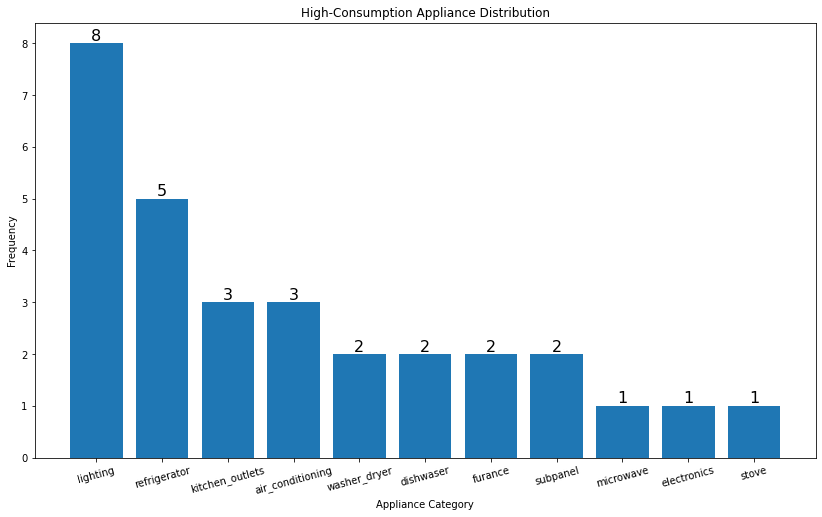

In [10]:
freq_count = defaultdict(int)

for i, df in data_frames.items():
  de = dataExploration(i, df)
  top5 = de.rank_appliance()
  for appliance in top5:
      name = appliance.split()[1]
      freq_count[name] += 1

freq_count =  [(k, v) for k, v in sorted(freq_count.items(), key=lambda x: -x[1])]
print('\n')
print('top 2 appliances of all houses: {}'.format([pair[0] for pair in freq_count[:2]]))

# plot
appliances = [pair[0] for pair in freq_count]
freq = [pair[1] for pair in freq_count]
plt.figure(figsize=(14, 8))
plt.bar(appliances, freq, color="tab:blue")  
plt.title('High-Consumption Appliance Distribution')
plt.xlabel('Appliance Category')
plt.xticks(rotation=15)   
plt.ylabel('Frequency')
for i, j in zip(appliances, freq):
    plt.text(i, j, j, ha='center', va='bottom', fontsize=16)
plt.show()


In [11]:
# random two day curve of house1 washdisher and refrigerator
house1 = data_frames[1]
mask = (house1['datetime'] > '2011-04-25 00:00:00') & (house1['datetime'] < '2011-04-27 00:00:00')
test_df = house1.loc[mask] 

timestamp = test_df['datetime']
dishwasher = test_df['6 dishwaser']
refrigerator = test_df['5 refrigerator']

**Train Test Split**


In [12]:
# Train test split on house 1 on 4/30/2011, about 60% training, 40% testing
house1 = data_frames[1]
house1_train = house1.iloc[:234362, :]
house1_test = house1.iloc[234362:, :]
X_train, y_train_ref, y_train_dishwasher = house1_train[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], house1_train['5 refrigerator'], house1_train['6 dishwaser']
X_test, y_test_ref, y_test_dishwasher = house1_test[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], house1_test['5 refrigerator'], house1_test['6 dishwaser']
print('X_train size: {}, y_train_ref size: {}'.format(X_train.shape, y_train_ref.shape))
print('X_test size: {}, y_test_ref size: {}'.format(X_test.shape, y_test_ref.shape))
# classification on/off state of refrigerator and dishwasher
y_train_ref_classification = y_train_ref.apply(lambda x: 0 if int(x) <= 7 else 1)
y_test_ref_classification = y_test_ref.apply(lambda x: 0 if int(x) <= 7 else 1)
y_train_dishwasher_classification = y_train_dishwasher.apply(lambda x: 0 if int(x) == 0 else 1)
y_test_dishwasher_classification = y_test_dishwasher.apply(lambda x: 0 if int(x) == 0 else 1)

X_train size: (234362, 6), y_train_ref size: (234362,)
X_test size: (172386, 6), y_test_ref size: (172386,)


**Baseline Model**


In [13]:
# baseline model using Logistic Regression
lr_clf1 = linear_model.LogisticRegression().fit(X_train, y_train_ref_classification)
lr_accuracy1 = metrics.accuracy_score(y_test_ref_classification, lr_clf1.predict(X_test))
print('Logistic Regression Accuracy of Refrigerator:', lr_accuracy1)
lr_clf2 = linear_model.LogisticRegression().fit(X_train, y_train_dishwasher_classification)
lr_accuracy2 = metrics.accuracy_score(y_test_dishwasher_classification, lr_clf2.predict(X_test))
print('Logistic Regression Accuracy of Dishwasher:', lr_accuracy2)

Logistic Regression Accuracy of Refrigerator: 0.7392827723829081
Logistic Regression Accuracy of Dishwasher: 0.9073068578654879


In [14]:
# baseline model using Linear Regression
lr1 = linear_model.LinearRegression().fit(X_train, y_train_ref)
print('Linear Regression RMSE of Refrigerator:', np.sqrt(metrics.mean_squared_error(y_test_ref, lr1.predict(X_test))))
print('Linear Regression MAE of Refrigerator:', np.sqrt(metrics.mean_absolute_error(y_test_ref, lr1.predict(X_test))))
lr2 = linear_model.LinearRegression().fit(X_train, y_train_dishwasher)
print('Linear Regression RMSE of Dishwasher:', np.sqrt(metrics.mean_squared_error(y_test_dishwasher, lr2.predict(X_test))))
print('Linear Regression MAE of Dishwasher:', np.sqrt(metrics.mean_absolute_error(y_test_dishwasher, lr2.predict(X_test))))

Linear Regression RMSE of Refrigerator: 84.19925967406539
Linear Regression MAE of Refrigerator: 8.04689858622648
Linear Regression RMSE of Dishwasher: 121.00577351830307
Linear Regression MAE of Dishwasher: 7.412858263069328


**Random Forest Classification and Regression**




In [15]:
# Random Forest Classification
rf_clf1 = ensemble.RandomForestClassifier(max_depth=10, random_state=0).fit(X_train, y_train_ref_classification)
rf_accuracy1 = metrics.accuracy_score(y_test_ref_classification, rf_clf1.predict(X_test))
print('Random Forest Classification Accuracy of Refrigerator:', rf_accuracy1)
rf_clf2 = ensemble.RandomForestClassifier(max_depth=10, random_state=0).fit(X_train, y_train_dishwasher_classification)
rf_accuracy2 = metrics.accuracy_score(y_test_dishwasher_classification, rf_clf2.predict(X_test))
print('Random Forest Classification Accuracy of Dishwasher:', rf_accuracy2)

Random Forest Classification Accuracy of Refrigerator: 0.9818778787140487
Random Forest Classification Accuracy of Dishwasher: 0.9272330699708793


In [16]:
# Random Forest Regression
start_time = time.time()
regressor1 = ensemble.RandomForestRegressor(n_estimators=5, random_state=10)
regressor1.fit(X_train, y_train_ref)
print("Train time {} seconds".format(time.time() - start_time))
y_predict_ref = regressor1.predict(X_test)
print('Random Forest Regression RMSE of Refrigerator:', np.sqrt(metrics.mean_squared_error(y_test_ref, y_predict_ref)))
print('Random Forest Regression MAE of Refrigerator:', np.sqrt(metrics.mean_absolute_error(y_test_ref, y_predict_ref)))
start_time = time.time()
regressor2 = ensemble.RandomForestRegressor(n_estimators=5, random_state=10)
regressor2.fit(X_train, y_train_dishwasher)
print("Train time {} seconds".format(time.time() - start_time))
y_predict_dishwasher = regressor2.predict(X_test)
print('Random Forest Regression RMSE of Dishwasher:', np.sqrt(metrics.mean_squared_error(y_test_dishwasher, y_predict_dishwasher)))
print('Random Forest Regression MAE of Dishwasher:', np.sqrt(metrics.mean_absolute_error(y_test_dishwasher, y_predict_dishwasher)))

Train time 4.6267991065979 seconds
Random Forest Regression RMSE of Refrigerator: 46.852122837932
Random Forest Regression MAE of Refrigerator: 3.657752650217556
Train time 3.649709463119507 seconds
Random Forest Regression RMSE of Dishwasher: 65.11049373604263
Random Forest Regression MAE of Dishwasher: 3.201354799562547


In [17]:
# Random Forest Regression on other appliances of house 1
# appliance_labels = list()
# lr_R_square = list()
# rf_R_square = list()
# lr_RMSE = list()
# rf_RMSE = list()

# for label in labels[1]:
#   if label not in ('1 mains', '2 mains'):
#     appliance_labels.append(label)
#     y_train = house1_train[label]
#     y_test = house1_test[label]
#     reg = linear_model.LinearRegression().fit(X_train, y_train)
#     #lr_R_square.append(metrics.r2_score(y_test, reg.predict(X_test)))
#     lr_RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))))
#     regressor = ensemble.RandomForestRegressor(n_estimators=5, random_state=10)
#     regressor.fit(X_train, y_train)
#     #rf_R_square.append(metrics.r2_score(y_test, regressor.predict(X_test)))
#     rf_RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test))))
  
# table1 = pd.DataFrame(zip(appliance_labels, lr_RMSE, rf_RMSE), columns=['Appliance', 'Linear Regression RMSE', 'Random Forest Regression RMSE'])
# table1

**KNN Classification and Regression**


In [18]:
# KNN classification
neigh1 = KNeighborsClassifier(n_neighbors = 100)
neigh1.fit(X_train, y_train_ref_classification)
y_predict = neigh1.predict(X_test)
knn_accuracy1 = metrics.accuracy_score(y_test_ref_classification,y_predict )
knn_cm1 = metrics.confusion_matrix(y_test_ref_classification, y_predict)
print('KNN Classification Accuracy of Refrigerator:', knn_accuracy1)
print('KNN Classification confusion_matrix of Refrigerator:\n', knn_cm1)
neigh2 = KNeighborsClassifier(n_neighbors = 100)
neigh2.fit(X_train, y_train_dishwasher_classification)
y_predict = neigh2.predict(X_test)
knn_accuracy2 = metrics.accuracy_score(y_test_dishwasher_classification,y_predict )
knn_cm2 = metrics.confusion_matrix(y_test_dishwasher_classification, y_predict)
print('KNN Classification Accuracy of dishwasher:', knn_accuracy2)
print('KNN Classification confusion_matrix of Dishwasher:\n', knn_cm2)

KNN Classification Accuracy of Refrigerator: 0.979864954230622
KNN Classification confusion_matrix of Refrigerator:
 [[125780   1846]
 [  1625  43135]]
KNN Classification Accuracy of dishwasher: 0.9151033146543223
KNN Classification confusion_matrix of Dishwasher:
 [[150626   6072]
 [  8563   7125]]


In [19]:
# KNN regression
start_time = time.time()
neigh1 = KNeighborsRegressor(n_neighbors=100)
neigh1.fit(X_train, y_train_ref)
print("Train time {} seconds".format(time.time() - start_time))
y_predict = neigh1.predict(X_test)
print('KNN Regression RMSE of Refrigerator:', np.sqrt(metrics.mean_squared_error(y_test_ref, y_predict)))
print('KNN Regression MAE of Refrigerator:', np.sqrt(metrics.mean_absolute_error(y_test_ref, y_predict)))
start_time = time.time()
neigh2 = KNeighborsRegressor(n_neighbors=100)
neigh2.fit(X_train, y_train_dishwasher)
print("Train time {} seconds".format(time.time() - start_time))
y_predict = neigh2.predict(X_test)
print('KNN Regression RMSE of Dishwasher:', np.sqrt(metrics.mean_squared_error(y_test_dishwasher, y_predict)))
print('KNN Regression MAE of Dishwasher:', np.sqrt(metrics.mean_absolute_error(y_test_dishwasher, y_predict)))

Train time 0.45789241790771484 seconds
KNN Regression RMSE of Refrigerator: 36.367459101130414
KNN Regression MAE of Refrigerator: 2.8998756872967997
Train time 0.4481027126312256 seconds
KNN Regression RMSE of Dishwasher: 50.54816953810688
KNN Regression MAE of Dishwasher: 2.4764111688286072


In [20]:
# KNN Regression on other appliances of house 1
# appliance_labels = list()
# lr_R_square = list()
# rf_R_square = list()
# lr_RMSE = list()
# rf_RMSE = list()

# for label in labels[1]:
#     if label not in ('1 mains', '2 mains'):
#         appliance_labels.append(label)
#         y_train = house1_train[label]
#         y_test = house1_test[label]
#         reg = linear_model.LinearRegression().fit(X_train, y_train)
#         #lr_R_square.append(metrics.r2_score(y_test, reg.predict(X_test)))
#         lr_RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))))
#         regressor = KNeighborsRegressor(n_neighbors=100)
#         regressor.fit(X_train, y_train)
#         #rf_R_square.append(metrics.r2_score(y_test, regressor.predict(X_test)))
#         rf_RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test))))
        
# table2 = pd.DataFrame(zip(appliance_labels, lr_RMSE, rf_RMSE), columns=['Appliance', 'Linear Regression RMSE', 'KNN Regression RMSE'])
# table2

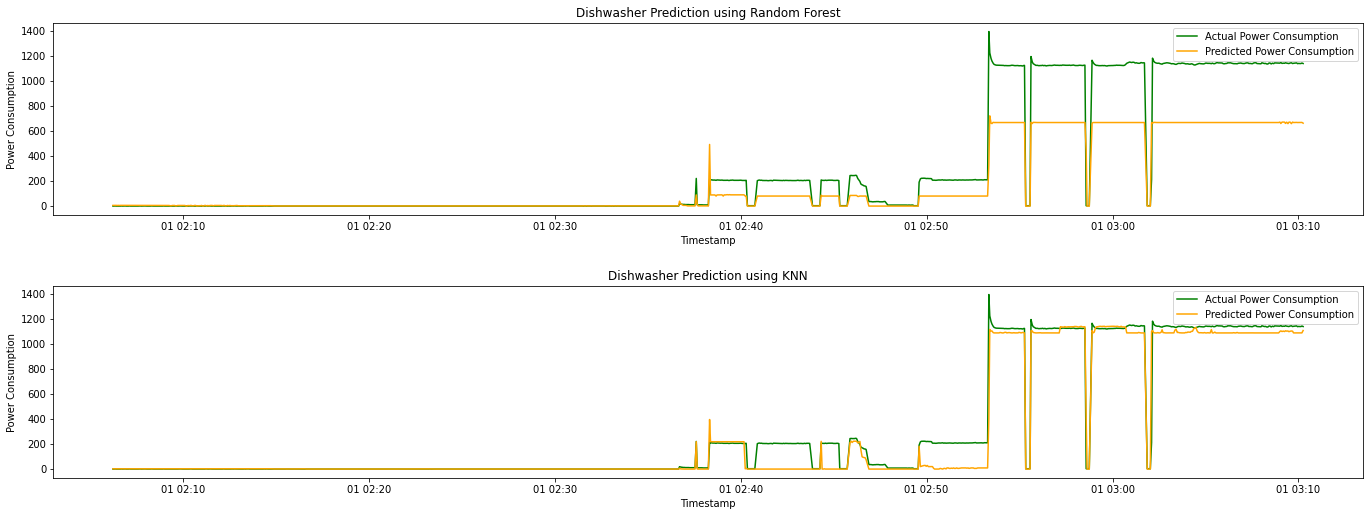

In [21]:
# Prediction demo
fig, axs = plt.subplots(2, figsize=(20,8))
fig.tight_layout(pad=5)
timestamp = house1_test['datetime'][2000:3000]
dishwasher = y_test_dishwasher[2000:3000]
dishwasher_rf = y_predict_dishwasher[2000:3000]
dishwasher_knn = y_predict[2000:3000]
axs[0].plot(timestamp, dishwasher, color='green', label='Actual Power Consumption')
axs[0].plot(timestamp, dishwasher_rf, color='orange', label='Predicted Power Consumption')
axs[0].legend(loc="upper right")
axs[0].set_title('Dishwasher Prediction using Random Forest')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Power Consumption')
axs[1].plot(timestamp, dishwasher, color='green', label='Actual Power Consumption')
axs[1].plot(timestamp, dishwasher_knn, color='orange', label='Predicted Power Consumption')
axs[1].legend(loc="upper right")
axs[1].set_title('Dishwasher Prediction using KNN')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Power Consumption')
fig.show()

**LSTM**



In [22]:
# reshape data
X_train = np.asarray(X_train).astype('float32').reshape(-1, 1, 6)
y_train_ref = np.asarray(y_train_ref).astype('float32').reshape(-1, 1, 1)
y_train_dishwasher = np.asarray(y_train_dishwasher).astype('float32').reshape(-1, 1, 1)
X_test = np.asarray(X_test).astype('float32').reshape(-1, 1, 6)
y_test_ref = np.asarray(y_test_ref).astype('float32').reshape(-1, 1)
y_test_dishwasher = np.asarray(y_test_dishwasher).astype('float32').reshape(-1, 1)

In [23]:
def long_short_term_memory(X_train, y_train, batch_size, epoch):

    np.random.seed(1)
    tensorflow.random.set_seed(2)
    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, input_shape = (1, 6)))
    model.add(Dropout(0.5))
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs = epoch, batch_size=batch_size)

    return model

In [24]:
ref_predict_lstm = long_short_term_memory(X_train, y_train_ref, 32, 10).predict(X_test).reshape(-1, 1)
print('LSTM RMSE of Refrigerator:', np.sqrt(metrics.mean_squared_error(y_test_ref, ref_predict_lstm)))
print('LSTM MAE of Refrigerator:', np.sqrt(metrics.mean_absolute_error(y_test_ref, ref_predict_lstm)))
dishwasher_predict_lstm = long_short_term_memory(X_train, y_train_dishwasher, 32, 10).predict(X_test).reshape(-1, 1)
print('LSTM RMSE of Dishwasher:', np.sqrt(metrics.mean_squared_error(y_test_dishwasher, dishwasher_predict_lstm)))
print('LSTM MAE of Dishwasher:', np.sqrt(metrics.mean_absolute_error(y_test_dishwasher, dishwasher_predict_lstm)))

Epoch 1/10
7324/7324 [==============================] - 50s 6ms/step - loss: 4448.1450
Epoch 2/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2347.0166
Epoch 3/10
7324/7324 [==============================] - 44s 6ms/step - loss: 2390.5673
Epoch 4/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2274.4714
Epoch 5/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2120.0338
Epoch 6/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2261.7019
Epoch 7/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2283.7637
Epoch 8/10
7324/7324 [==============================] - 46s 6ms/step - loss: 2302.1378
Epoch 9/10
7324/7324 [==============================] - 45s 6ms/step - loss: 2174.2795
Epoch 10/10
7324/7324 [==============================] - 46s 6ms/step - loss: 2136.5003
LSTM RMSE of Refrigerator: 53.1236
LSTM MAE of Refrigerator: 4.4974627
Epoch 1/10
7324/7324 [==============================] - 50

**CNN**


In [25]:
def CNN(X_train, y_train, batch_size, epoch):

    np.random.seed(1)
    tensorflow.random.set_seed(2)
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu', strides=1, padding='valid', data_format='channels_last', input_shape=(1,6)))
    model.add(MaxPooling1D(pool_size=1, strides=None, padding='valid', data_format='channels_last')) 
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', strides=1, padding='valid', data_format='channels_last', input_shape=(1,6)))
    model.add(MaxPooling1D(pool_size=1, strides=None, padding='valid', data_format='channels_last')) 
    model.add(Conv1D(filters=32, kernel_size=1, activation='relu', strides=1, padding='valid', data_format='channels_last', input_shape=(1,6)))
    model.add(MaxPooling1D(pool_size=1, strides=None, padding='valid', data_format='channels_last')) 
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Dense(units=1))
    model.compile(optimizer='Adam', loss='mse', loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
    model.fit(X_train, y_train, batch_size = batch_size, epochs = epoch)
    
    return model

In [26]:
cnn_ref_pred = CNN(X_train, y_train_ref, 20, 25).predict(X_test).reshape(-1, 1)
print('CNN RMSE of Refrigerator:', np.sqrt(metrics.mean_squared_error(y_test_ref, cnn_ref_pred)))
print('CNN MAE of Refrigerator:', np.sqrt(metrics.mean_absolute_error(y_test_ref, cnn_ref_pred)))
cnn_dishwasher_pred = CNN(X_train, y_train_dishwasher, 64, 25).predict(X_test).reshape(-1, 1)
print('CNN RMSE of Dishwasher:', np.sqrt(metrics.mean_squared_error(y_test_dishwasher, cnn_dishwasher_pred)))
print('CNN MAE of Dishwasher:', np.sqrt(metrics.mean_absolute_error(y_test_dishwasher, cnn_dishwasher_pred)))

Epoch 1/25
11719/11719 [==============================] - 51s 4ms/step - loss: 2482.0565
Epoch 2/25
11719/11719 [==============================] - 52s 4ms/step - loss: 1457.3767
Epoch 3/25
11719/11719 [==============================] - 52s 4ms/step - loss: 1437.0258
Epoch 4/25
11719/11719 [==============================] - 40s 3ms/step - loss: 1296.9984
Epoch 5/25
11719/11719 [==============================] - 42s 4ms/step - loss: 1253.7736
Epoch 6/25
11719/11719 [==============================] - 41s 3ms/step - loss: 1298.0238
Epoch 7/25
11719/11719 [==============================] - 41s 3ms/step - loss: 1280.9741
Epoch 8/25
11719/11719 [==============================] - 41s 3ms/step - loss: 1325.6185
Epoch 9/25
11719/11719 [==============================] - 41s 3ms/step - loss: 1146.2739
Epoch 10/25
11719/11719 [==============================] - 40s 3ms/step - loss: 1138.8201
Epoch 11/25
11719/11719 [==============================] - 40s 3ms/step - loss: 1256.7650
Epoch 12/25
11719/1

**Appliances Comparison**

1.   Kitchen outlets: training 1, 2, 3, 4, testing 5, 6
2.   Stove: training 1, 2, 4, testing 6



In [27]:
new_house1 = data_frames[1][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains', '14 stove']].rename(columns = {'14 stove': 'stove'})
house1_kitchen_outlets = data_frames[1][['7 kitchen_outlets', '8 kitchen_outlets', '15 kitchen_outlets', '16 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house1 = new_house1.merge(house1_kitchen_outlets, how='outer', left_index=True, right_index=True)

new_house2 = data_frames[2][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains', '5 stove']].rename(columns = {'5 stove': 'stove'})
house2_kitchen_outlets = data_frames[2][['3 kitchen_outlets', '8 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house2 = new_house2.merge(house2_kitchen_outlets, how='outer', left_index=True, right_index=True)

new_house3 = data_frames[3][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']]
house3_kitchen_outlets = data_frames[3][['21 kitchen_outlets', '22 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house3 = new_house3.merge(house3_kitchen_outlets, how='outer', left_index=True, right_index=True)

new_house4 = data_frames[4][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains', '8 stove']].rename(columns = {'8 stove': 'stove'})
house4_kitchen_outlets = data_frames[4][['5 kitchen_outlets', '14 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house4 = new_house4.merge(house4_kitchen_outlets, how='outer', left_index=True, right_index=True)

new_house5 = data_frames[5][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']]
house5_kitchen_outlets = data_frames[5][['24 kitchen_outlets', '25 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house5 = new_house5.merge(house5_kitchen_outlets, how='outer', left_index=True, right_index=True)

new_house6 = data_frames[6][['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains', '5 stove']].rename(columns = {'5 stove': 'stove'})
house6_kitchen_outlets = data_frames[6][['3 kitchen_outlets', '13 kitchen_outlets']].sum(axis=1).to_frame().rename(columns = {0: 'kitchen_outlets'})
new_house6 = new_house6.merge(house6_kitchen_outlets, how='outer', left_index=True, right_index=True)


In [28]:
# aggregate kitchen outlets datasets
kitchen_outlets_train_data = pd.concat([new_house1, new_house2, new_house3, new_house4], ignore_index=True)
kitchen_outlets_test_data = pd.concat([new_house5, new_house6], ignore_index=True)
X_train_kitchen_outlets, y_train_kitchen_outlets = kitchen_outlets_train_data[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], kitchen_outlets_train_data[['kitchen_outlets']]
X_test_kitchen_outlets, y_test_kitchen_outlets = kitchen_outlets_test_data[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], kitchen_outlets_test_data[['kitchen_outlets']]
print('X_train_kitchen_outlets size: {}, y_train_kitchen_outlets size: {}, X_test_kitchen_outlets size: {}, y_test_kitchen_outlets size: {}'.format(X_train_kitchen_outlets.shape, y_train_kitchen_outlets.shape, X_test_kitchen_outlets.shape, y_test_kitchen_outlets.shape))

X_train_kitchen_outlets size: (1527814, 6), y_train_kitchen_outlets size: (1527814, 1), X_test_kitchen_outlets size: (269643, 6), y_test_kitchen_outlets size: (269643, 1)


In [29]:
# aggregate stove datasets
stove_train_data = pd.concat([new_house1, new_house2, new_house4], ignore_index=True)
stove_test_data = pd.concat([new_house6], ignore_index=True)
X_train_stove, y_train_stove = stove_train_data[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], stove_train_data[['stove']]
X_test_stove, y_test_stove = stove_test_data[['Month', 'Day', 'Hour', 'isWeekend', '1 mains', '2 mains']], stove_test_data[['stove']]
print('X_train_stove size: {}, y_train_stove size: {}, X_test_stove size: {}, y_test_stove size: {}'.format(X_train_stove.shape, y_train_stove.shape, X_test_stove.shape, y_test_stove.shape))

X_train_stove size: (1151664, 6), y_train_stove size: (1151664, 1), X_test_stove size: (192192, 6), y_test_stove size: (192192, 1)


In [30]:
# Random Forest Regression
regressor1 = ensemble.RandomForestRegressor(n_estimators=5, random_state=10)
regressor1.fit(X_train_kitchen_outlets, np.asarray(y_train_kitchen_outlets).reshape(-1))
y_predict_kitchen_outlets = regressor1.predict(X_test_kitchen_outlets)
print('Random Forest Regression RMSE of Kitchen Outlets:', np.sqrt(metrics.mean_squared_error(y_test_kitchen_outlets, y_predict_kitchen_outlets)))
print('Random Forest Regression MAE of Kitchen Outlets:', np.sqrt(metrics.mean_absolute_error(y_test_kitchen_outlets, y_predict_kitchen_outlets)))

regressor2 = ensemble.RandomForestRegressor(n_estimators=5, random_state=10)
regressor2.fit(X_train_stove, np.asarray(y_train_stove).reshape(-1))
y_predict_stove = regressor2.predict(X_test_stove)
print('Random Forest Regression RMSE of Stove:', np.sqrt(metrics.mean_squared_error(y_test_stove, y_predict_stove)))
print('Random Forest Regression MAE of Stove:', np.sqrt(metrics.mean_absolute_error(y_test_stove, y_predict_stove)))

Random Forest Regression RMSE of Kitchen Outlets: 108.87478999184123
Random Forest Regression MAE of Kitchen Outlets: 5.809770168516705
Random Forest Regression RMSE of Stove: 70.16694357831634
Random Forest Regression MAE of Stove: 3.322216545178877


In [31]:
# KNN regression
neigh1 = KNeighborsRegressor(n_neighbors=50)
neigh1.fit(X_train_kitchen_outlets, y_train_kitchen_outlets)
y_predict_kitchen_outlets = neigh1.predict(X_test_kitchen_outlets)
print('KNN Regression RMSE of Kitchen Outlets:', np.sqrt(metrics.mean_squared_error(y_test_kitchen_outlets, y_predict_kitchen_outlets)))
print('KNN Regression MAE of Kitchen Outlets:', np.sqrt(metrics.mean_absolute_error(y_test_kitchen_outlets, y_predict_kitchen_outlets)))

neigh2 = KNeighborsRegressor(n_neighbors=50)
neigh2.fit(X_train_stove, y_train_stove)
y_predict_stove = neigh2.predict(X_test_stove)
print('KNN Regression RMSE of Stove:', np.sqrt(metrics.mean_squared_error(y_test_stove, y_predict_stove)))
print('KNN Regression MAE of Stove:', np.sqrt(metrics.mean_absolute_error(y_test_stove, y_predict_stove)))

KNN Regression RMSE of Kitchen Outlets: 126.85981815827328
KNN Regression MAE of Kitchen Outlets: 6.030006495071752
KNN Regression RMSE of Stove: 62.35743044987854
KNN Regression MAE of Stove: 2.2202993791754375


In [32]:
X_train_kitchen_outlets = np.asarray(X_train_kitchen_outlets).astype('float32').reshape(-1, 1, 6)
X_test_kitchen_outlets = np.asarray(X_test_kitchen_outlets).astype('float32').reshape(-1, 1, 6)
y_train_kitchen_outlets = np.asarray(y_train_kitchen_outlets).astype('float32').reshape(-1, 1, 1)
y_test_kitchen_outlets = np.asarray(y_test_kitchen_outlets).astype('float32').reshape(-1, 1)
X_train_stove = np.asarray(X_train_stove).astype('float32').reshape(-1, 1, 6)
X_test_stove = np.asarray(X_test_stove).astype('float32').reshape(-1, 1, 6)
y_train_stove = np.asarray(y_train_stove).astype('float32').reshape(-1, 1, 1)
y_test_stove = np.asarray(y_test_stove).astype('float32').reshape(-1, 1)

In [33]:
# LSTM
kitchen_outlets_predict_lstm = long_short_term_memory(X_train_kitchen_outlets, y_train_kitchen_outlets, 32, 10).predict(X_test_kitchen_outlets).reshape(-1, 1)
print('LSTM RMSE of Kitchen Outlets:', np.sqrt(metrics.mean_squared_error(y_test_kitchen_outlets, kitchen_outlets_predict_lstm)))
print('LSTM MAE of Kitchen Outlets:', np.sqrt(metrics.mean_absolute_error(y_test_kitchen_outlets, kitchen_outlets_predict_lstm)))

stove_predict_lstm = long_short_term_memory(X_train_stove, y_train_stove, 32, 10).predict(X_test_stove).reshape(-1, 1)
print('LSTM RMSE of Stove:', np.sqrt(metrics.mean_squared_error(y_test_stove, stove_predict_lstm)))
print('LSTM MAE of Stove:', np.sqrt(metrics.mean_absolute_error(y_test_stove, stove_predict_lstm)))

Epoch 1/10
47745/47745 [==============================] - 303s 6ms/step - loss: 7106.2460
Epoch 2/10
47745/47745 [==============================] - 297s 6ms/step - loss: 6884.3955
Epoch 3/10
47745/47745 [==============================] - 296s 6ms/step - loss: 6951.7086
Epoch 4/10
47745/47745 [==============================] - 294s 6ms/step - loss: 6822.7302
Epoch 5/10
47745/47745 [==============================] - 298s 6ms/step - loss: 6921.4295
Epoch 6/10
47745/47745 [==============================] - 297s 6ms/step - loss: 6723.8278
Epoch 7/10
47745/47745 [==============================] - 293s 6ms/step - loss: 6864.2567
Epoch 8/10
47745/47745 [==============================] - 294s 6ms/step - loss: 6862.8802
Epoch 9/10
47745/47745 [==============================] - 290s 6ms/step - loss: 6919.6092
Epoch 10/10
47745/47745 [==============================] - 293s 6ms/step - loss: 6841.2880
LSTM RMSE of Kitchen Outlets: 60.64356
LSTM MAE of Kitchen Outlets: 5.061346
Epoch 1/10
35990/35990

In [34]:
# CNN
cnn_kitchen_outlets_pred = CNN(X_train_kitchen_outlets, y_train_kitchen_outlets, 64, 25).predict(X_test_kitchen_outlets).reshape(-1, 1)
print('CNN RMSE of Kitchen Outlets:', np.sqrt(metrics.mean_squared_error(y_test_kitchen_outlets, cnn_kitchen_outlets_pred)))
print('CNN MAE of Kitchen Outlets:', np.sqrt(metrics.mean_absolute_error(y_test_kitchen_outlets, cnn_kitchen_outlets_pred)))

cnn_stove_pred = CNN(X_train_stove, y_train_stove, 64, 25).predict(X_test_stove).reshape(-1, 1)
print('CNN RMSE of Stove:', np.sqrt(metrics.mean_squared_error(y_test_stove, cnn_stove_pred)))
print('CNN MAE of Stove:', np.sqrt(metrics.mean_absolute_error(y_test_stove, cnn_stove_pred)))

Epoch 1/25
23873/23873 [==============================] - 64s 3ms/step - loss: 6410.9922
Epoch 2/25
23873/23873 [==============================] - 63s 3ms/step - loss: 5396.2958
Epoch 3/25
23873/23873 [==============================] - 63s 3ms/step - loss: 4484.8558
Epoch 4/25
23873/23873 [==============================] - 63s 3ms/step - loss: 4077.9172
Epoch 5/25
23873/23873 [==============================] - 63s 3ms/step - loss: 3778.9792
Epoch 6/25
23873/23873 [==============================] - 63s 3ms/step - loss: 3494.6016
Epoch 7/25
23873/23873 [==============================] - 63s 3ms/step - loss: 3372.5823
Epoch 8/25
23873/23873 [==============================] - 63s 3ms/step - loss: 3249.8864
Epoch 9/25
23873/23873 [==============================] - 62s 3ms/step - loss: 3153.2006
Epoch 10/25
23873/23873 [==============================] - 62s 3ms/step - loss: 2967.1110
Epoch 11/25
23873/23873 [==============================] - 63s 3ms/step - loss: 2964.1864
Epoch 12/25
23873/2